# HUDF F105W SEP Analysis

In this notebook, I repeat the SEP tutorial steps, but this time on a real Hubble image:  
**the HUDF F105W drizzled mosaic**.

I will:

1. Load the HUDF F105W FITS file  
2. Display the raw image  
3. Estimate and subtract the background  
4. Detect sources in the field  
5. Count the total number of detected objects  
6. Measure fluxes using aperture photometry  
7. Plot a histogram of fluxes  
8. Compute the mean, median, and standard deviation  
9. Identify the largest flux outlier and mark its location on the image  

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import sep

from matplotlib import rcParams
rcParams['figure.figsize'] = [12., 10.]

from astropy.io import fits

import warnings
warnings.filterwarnings("ignore")

## Loading the HUDF F105W FITS Image

Here I load the HUDF F105W image using `fits.getdata()`. This function automatically selects the first HDU that contains array data, which in this case is the science image.

I convert the data to `float32` because SEP requires floating-point input.

In [45]:
data_105 = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits").astype(np.float32)
data_105.shape, data_105.dtype

((3600, 3600), dtype('float32'))

## Displaying the HUDF F105W Image

I display the raw image using a grayscale stretch based on the mean and standard deviation.
This helps reveal faint galaxies and noise structure in the deep field.

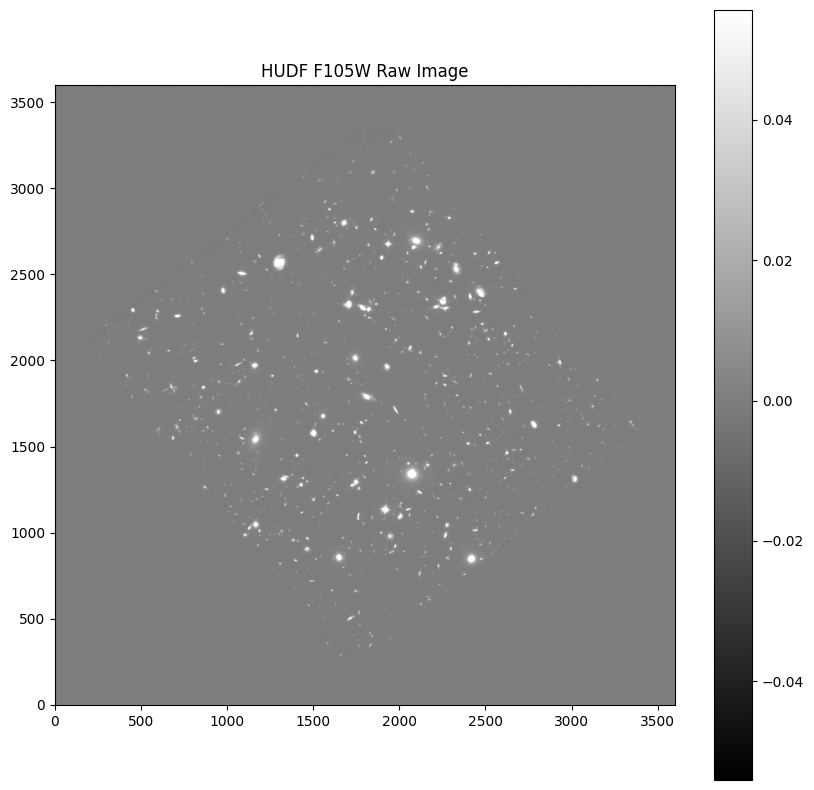

In [46]:
m, s = np.mean(data_105), np.std(data_105)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(data_105, cmap="gray", origin="lower", vmin=m - s, vmax=m + s)

fig.colorbar(im, ax=ax)
ax.set_title("HUDF F105W Raw Image")

fig.savefig("udf_f105w_raw.png", dpi=200, bbox_inches="tight")
plt.show()

## Background Estimation

Next, I estimate a smooth 2D background and an RMS noise map using SEP.
I subtract this background before detecting sources.

In [47]:
bkg_udf = sep.Background(data_105)

print("Global background:", bkg_udf.globalback)
print("Global RMS:", bkg_udf.globalrms)

data_105_sub = data_105 - bkg_udf

Global background: 0.0
Global RMS: 0.0005398219218477607


## Source Extraction

I detect sources using `sep.extract()` with a threshold of 1.5σ above the background RMS.
This is very sensitive and will detect many faint galaxies in the HUDF.

In [48]:
objects_udf = sep.extract(data_105_sub, thresh=1.5, err=bkg_udf.globalrms)

num_sources = len(objects_udf)
num_sources

8640

## Number of Detected Sources

The number displayed above is the total number of objects SEP detected in the HUDF F105W image.

## Aperture Photometry

To measure fluxes, I use 3-pixel radius circular apertures, matching the original SEP tutorial.

I then create a mask to keep only good measurements.

In [49]:
flux_udf, fluxerr_udf, flag_udf = sep.sum_circle(data_105_sub, objects_udf['x'], objects_udf['y'], 3.0, err=bkg_udf.globalrms, gain=1.0)

good = flag_udf == 0
flux_good = flux_udf[good]

len(flux_good)

8640

## Flux Histogram (Logarithmic Scale)

Because the HUDF contains many very faint objects and a small number of bright ones, the flux distribution spans several orders of magnitude. A linear histogram hides this structure.

Here I plot the flux distribution using a **logarithmic x-axis**, which reveals the full shape of the distribution much more clearly.

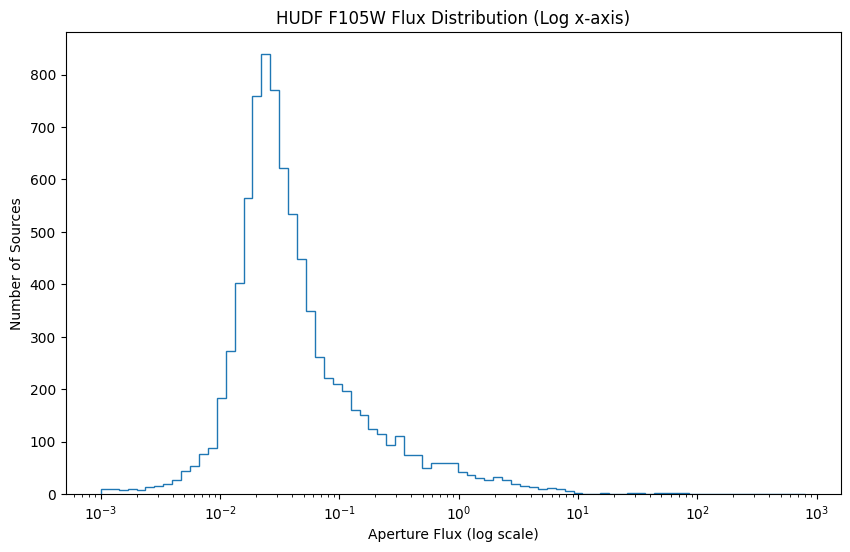

In [50]:
bins = np.logspace(np.log10(max(flux_good[flux_good > 0].min(), 1e-3)),np.log10(flux_good.max()),80)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(flux_good[flux_good > 0], bins=bins, histtype="step")

ax.set_xscale("log")
ax.set_xlabel("Aperture Flux (log scale)")
ax.set_ylabel("Number of Sources")
ax.set_title("HUDF F105W Flux Distribution (Log x-axis)")

fig.savefig("udf_f105w_flux_hist_log.png", dpi=200, bbox_inches="tight")
plt.show()

## Statistical Properties of the Flux Distribution

Now that I have measured fluxes for all detected objects, I compute the mean, median, and standard deviation of the distribution. These values help summarize the overall brightness of sources in the HUDF F105W image.

In [51]:
mean_flux = np.mean(flux_good)
median_flux = np.median(flux_good)
std_flux = np.std(flux_good)

mean_flux, median_flux, std_flux

(np.float64(0.3618620007201894),
 np.float64(0.03095655805023853),
 np.float64(9.243527842777791))

## Identifying the Largest Flux Outlier

To find unusually bright sources, I compute the z-score for each flux value.

I then locate the object with the largest absolute z-value and record:
- its flux  
- its z-score  
- its x and y coordinates in the image

This tells me which detected source is the most statistically unusual.

In [52]:
z = (flux_good - mean_flux) / std_flux
idx_max = np.argmax(np.abs(z))

outlier_flux = flux_good[idx_max]
outlier_z = z[idx_max]

good_indices = np.nonzero(good)[0]
obj_index = good_indices[idx_max]

x_out = objects_udf['x'][obj_index]
y_out = objects_udf['y'][obj_index]

outlier_flux, outlier_z, (x_out, y_out)

(np.float64(807.2972835731507),
 np.float64(87.2973431029269),
 (np.float64(1914.2549094866436), np.float64(1134.3164850725645)))

## Marking the Outlier on the HUDF Image

Here I plot the background-subtracted HUDF image again and mark the position of the brightest statistical outlier with a red “X.”

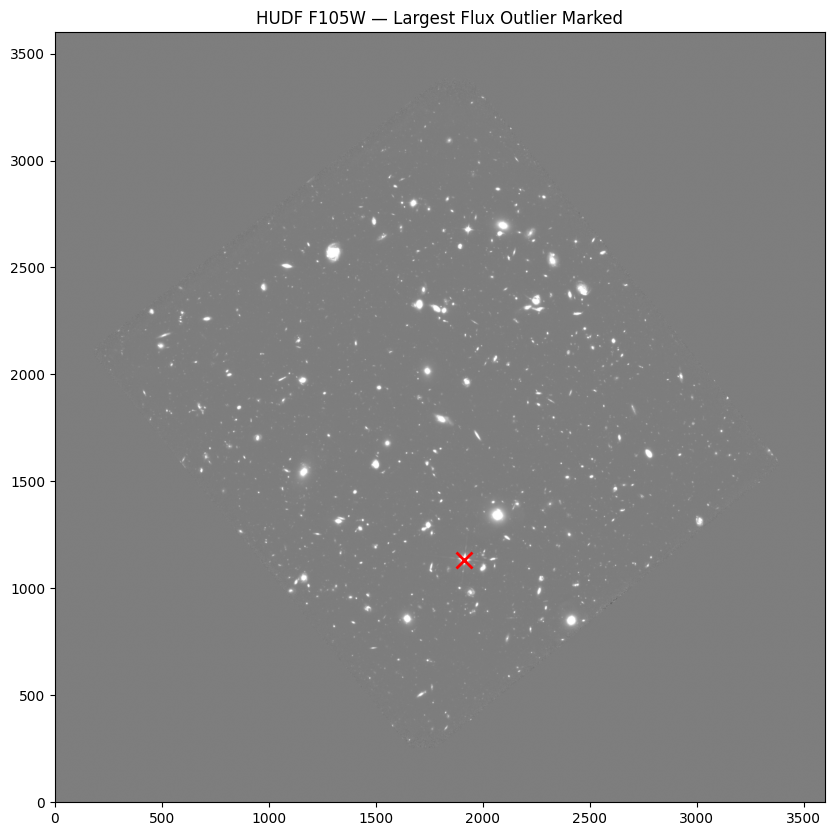

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
m, s = np.mean(data_105_sub), np.std(data_105_sub)

ax.imshow(data_105_sub, cmap="gray", origin="lower", vmin=m - s, vmax=m + s)

# Mark the outlier
ax.plot(x_out, y_out, "rx", markersize=12, mew=2)
ax.set_title("HUDF F105W — Largest Flux Outlier Marked")

fig.savefig("udf_f105w_outlier_marked.png", dpi=200, bbox_inches="tight")
plt.show()